<a href="https://colab.research.google.com/github/aga55-star/ORIE-4580-HW/blob/main/ORIE%204580%20HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ORIE 4580/5580/5581 Assignment 4

#### Students: A. Agarwal (aga55) and D. Fuentes (dwf64)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Thursday October 2, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

<hr><hr>

# Question 1: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

<hr>

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.

<hr>

## Ans.

In [ ]:
import numpy as np

def simulate_wait_times(
    n_passengers=10000,
    passenger_arrival_minutes=1000.0,
    train_time=10.0,
    do_bootstrap=True,
    n_boot=10000
):

    rng = np.random.default_rng(1)

    arrivals = rng.uniform(0.0, passenger_arrival_minutes, size=n_passengers)
    arrivals_sorted = np.sort(arrivals)

    waits = (train_time - np.mod(arrivals_sorted, train_time)) % train_time

    mean_wait = waits.mean()
    std_wait = waits.std(ddof=1)
    se_wait = std_wait / np.sqrt(n_passengers)

    z = 1.96
    ci_normal = (mean_wait - z * se_wait, mean_wait + z * se_wait)

    stats = {
        "mean_wait": float(mean_wait),
        "std_wait": float(std_wait),
        "se_wait": float(se_wait),
        "ci_normal_95": tuple(map(float, ci_normal)),
    }


    return arrivals_sorted, waits, stats


arrivals_sorted, waits, stats = simulate_wait_times()

print(f"Passengers simulated: {len(arrivals_sorted)}")
print(f"Sample mean wait time: {stats['mean_wait']:.2f} minutes")
print(f"95% CI (Normal approx): [{stats['ci_normal_95'][0]:.2f}, {stats['ci_normal_95'][1]:.2f}]")



Passengers simulated: 10000
Sample mean wait time: 5.05 minutes
95% CI (Normal approx): [4.99, 5.11]


<hr>

**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.

<hr>

## Ans.

In [ ]:
def simulate_wait_times_exp(arrivals_sorted, mean_headway=10.0, seed=1):
    rng = np.random.default_rng(seed)
    horizon = float(arrivals_sorted[-1])

    train_times = []
    t = 0.0
    while not train_times or train_times[-1] < horizon:
        t += rng.exponential(mean_headway)
        train_times.append(t)
    train_times = np.array(train_times)

    idx = np.searchsorted(train_times, arrivals_sorted, side="left")
    waits = train_times[idx] - arrivals_sorted

    mean_wait = float(np.mean(waits))
    se_wait   = float(np.std(waits, ddof=1) / np.sqrt(len(waits)))
    z = 1.96
    ci_95 = (mean_wait - z*se_wait, mean_wait + z*se_wait)

    stats_exp = {
        "mean_wait": float(mean_wait),
        "std_wait": float(np.std(waits, ddof=1)),
        "se_wait": float(se_wait),
        "ci_normal_95": tuple(map(float, ci_95)),
    }

    return waits, mean_wait, ci_95, train_times, stats_exp


waits_exp, mean_wait, ci_wait, train_times, stats_exp = simulate_wait_times_exp(arrivals_sorted, mean_headway=10.0)

print(f"Sample mean wait time = {mean_wait:.2f} minutes")
print(f"95% CI = [{ci_wait[0]:.2f}, {ci_wait[1]:.2f}]")


Sample mean wait time = 12.78 minutes
95% CI = [12.48, 13.08]


<hr>

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

<hr>

In [ ]:
def analyze_interarrivals(train_times):
    inter_arrivals = np.diff(train_times)

    mean_ia = inter_arrivals.mean()
    std_ia = inter_arrivals.std(ddof=1)
    se_ia = std_ia / np.sqrt(len(inter_arrivals))
    z = 1.96
    ci_ia = (mean_ia - z * se_ia, mean_ia + z * se_ia)

    return mean_ia, ci_ia, inter_arrivals

mean_ia, ci_ia, inter_arrivals = analyze_interarrivals(train_times)

print(f"Sample mean: {mean_ia:.2f} min")
print(f"95% CI: [{ci_ia[0]:.2f}, {ci_ia[1]:.2f}]")


Sample mean: 10.41 min
95% CI: [7.88, 12.95]


<hr>

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

<hr>

## Ans.

In [ ]:
def interarrival_from_wait(stats, label=""):
    mean_I = 2 * stats["mean_wait"]
    ci_I = (2 * stats["ci_normal_95"][0], 2 * stats["ci_normal_95"][1])
    print(f"{label}")
    print(f"Mean passenger-experienced inter-arrival I = {mean_I:.2f} min")
    print(f"95% CI = [{ci_I[0]:.2f}, {ci_I[1]:.2f}]")
    return mean_I, ci_I

# Example: assuming you already have stats_a (from part a) and stats_b (from part b)
mean_I_a, ci_I_a = interarrival_from_wait(stats, "Deterministic trains")
mean_I_b, ci_I_b = interarrival_from_wait(stats_exp, "Exponential trains")


print("\nIn the deterministic case, every passenger experiences a fixed 10-minute gap, so the average wait is half of that (5 minutes).")
print("In the exponential case, passengers are more likely to arrive during long gaps (inspection paradox), so the average gap they see is about 25 minutes.")
print("This makes their expected wait half of 25, or about 12.5 minutes — double the deterministic case despite the same 10-minute average schedule.")



Deterministic trains
Mean passenger-experienced inter-arrival I = 10.10 min
95% CI = [9.98, 10.21]
Exponential trains
Mean passenger-experienced inter-arrival I = 25.56 min
95% CI = [24.96, 26.17]

In the deterministic case, every passenger experiences a fixed 10-minute gap, so the average wait is half of that (5 minutes).
In the exponential case, passengers are more likely to arrive during long gaps (inspection paradox), so the average gap they see is about 25 minutes.
This makes their expected wait half of 25, or about 12.5 minutes — double the deterministic case despite the same 10-minute average schedule.


**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  

<hr><hr>

# Question 2: Generating random samples in some given set (20 pts)

<hr>

**(a)** We want to sample points which are uniformly distributed in the set  $\mathbb{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).

<hr>

## Ans.

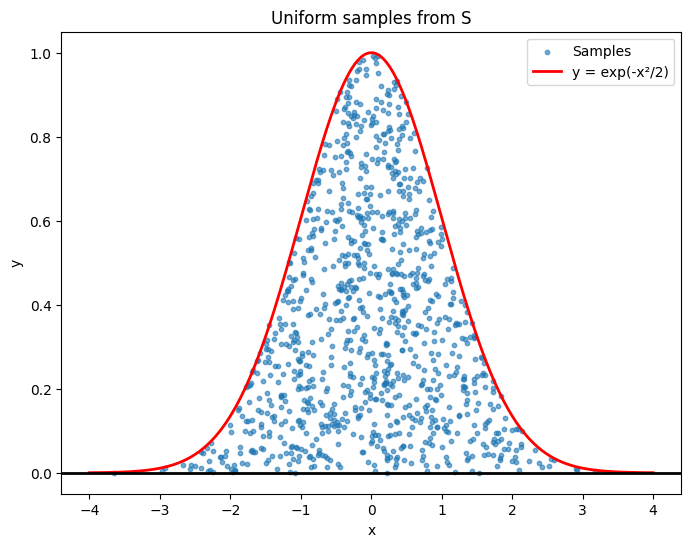

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000
rng = np.random.default_rng(42)

X = rng.normal(0, 1, size=n)

Y = rng.uniform(0, np.exp(-X**2 / 2))

plt.figure(figsize=(8,6))
plt.scatter(X, Y, s=10, alpha=0.6, label="Samples")

x_vals = np.linspace(-4, 4, 400)
plt.plot(x_vals, np.exp(-x_vals**2 / 2), color="red", lw=2, label="y = exp(-x²/2)")
plt.axhline(0, color="black", lw=2)

plt.title("Uniform samples from S")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


<hr>

**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).

<hr>

## Ans.

Looking at the histogram below, we can see that instead of being flat, which is what we would expect if the points were uniformly distrubted, we actually have variation in angle denisities. This stems from the fact that points on the corners of the square $[-1,1]^2$ are pushed to diagonals at $45°, 135°, etc$

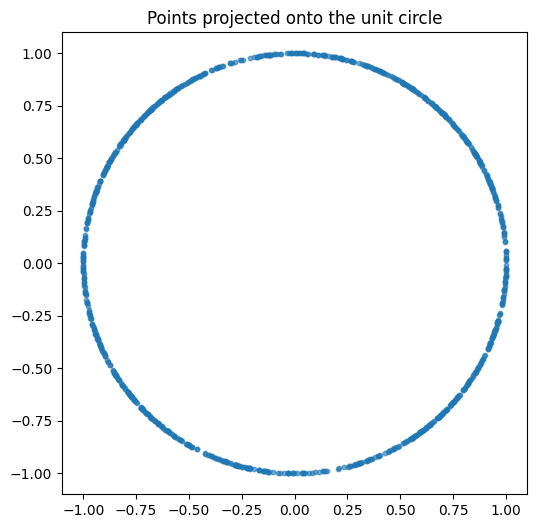

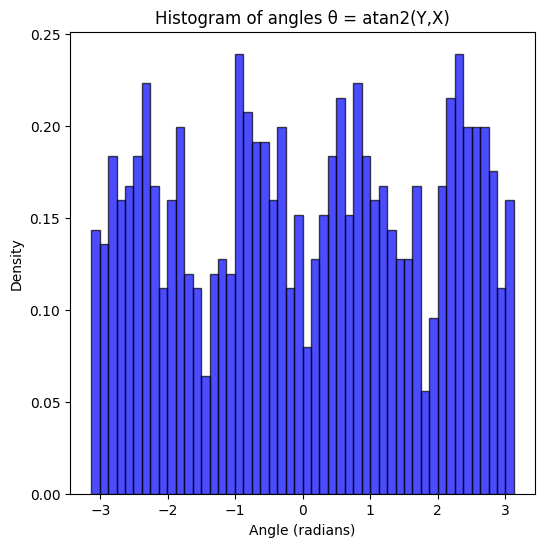

In [ ]:
n = 1000
rng = np.random.default_rng(1)

U = rng.uniform(-1, 1, size=n)
V = rng.uniform(-1, 1, size=n)

norms = np.sqrt(U**2 + V**2)
X = U / norms
Y = V / norms

plt.figure(figsize=(6,6))
plt.scatter(X, Y, s=10, alpha=0.6)
plt.title("Points projected onto the unit circle")
plt.show()

theta = np.arctan2(Y, X)
plt.figure(figsize=(6,6))
plt.hist(theta, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title("Histogram of angles θ = atan2(Y,X)")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.show()


<hr>

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathbb{N}(0,I_2)$), and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

<hr>

## Ans.

In part (b), projecting points from the square $[-1,1]^2$ onto the circle does not yield uniform angles, because the square is not rotationally symmetric; directions toward the diagonals are overrepresented. In part (c), sampling $(Z_i, W_i) \sim \mathbb{N}(0,I_2)$ and projecting onto the unit circle produces uniform points, since the 2-D standard normal distribution is rotationally symmetric.  After normalization, the radius cancels out and only the angle remains, which is distributed uniformly on $[0,2\pi)$.  


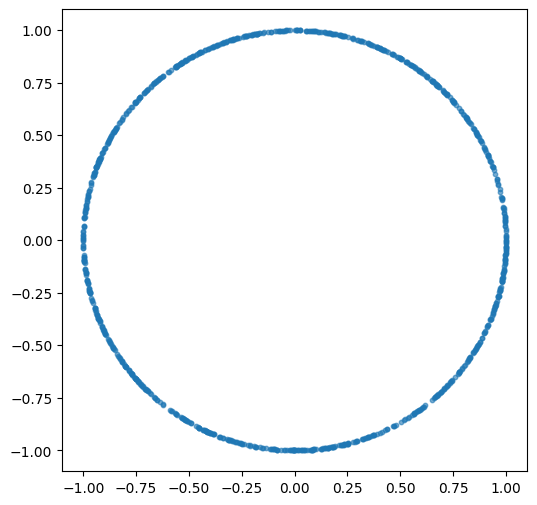

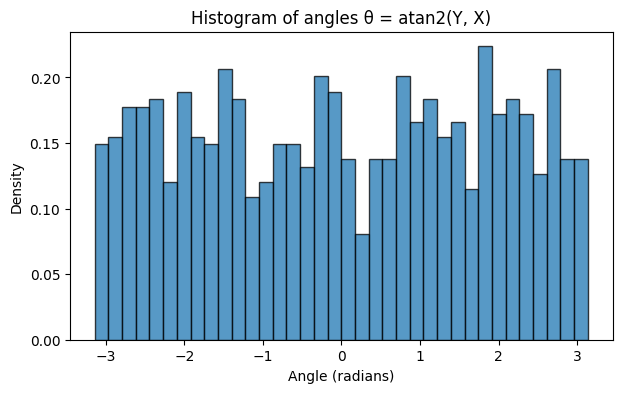

In [ ]:
n = 1000
rng = np.random.default_rng(1)

Z = rng.normal(0, 1, size=n)
W = rng.normal(0, 1, size=n)
R = np.sqrt(Z**2 + W**2)
X = Z / R
Y = W / R

plt.figure(figsize=(6,6))
plt.scatter(X, Y, s=10, alpha=0.6)
plt.show()

theta = np.arctan2(Y, X)  # in [-pi, pi]
plt.figure(figsize=(7,4))
plt.hist(theta, bins=36, density=True, edgecolor="black", alpha=0.75)
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Histogram of angles θ = atan2(Y, X)")
plt.show()


<hr><hr>

# Question 3: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


<hr>

## Ans
$\sigma_1 = 0.25$,
$\sigma_2 = 0.1$,
$\sigma_3 = 0.3$,

Let $R_1$, $R_2$, $R_3$ be annual real returns for US stocks, bonds, and em bonds. $R _i$ ~ $N(\mu_i,\sigma_i^2)$

$P(R_1 > 0, R_2 > 0, R_3 > 0) = \prod_{i=1}^{3} P(R_i > 0) = \prod_{i=1}^{3} \phi (\frac{\mu_i}{\sigma_i})$

$P(R_1 > 0) = \phi(\frac{0.14}{0.25}) = \phi(0.56) = 0.7123$\
$P(R_1 > 0) = \phi(\frac{0.07}{0.1}) = \phi(0.7) = 0.7580$\
$P(R_1 > 0) = \phi(\frac{0.16}{0.3}) = \phi(0.53) = 0.7031$

$P(R_1 > 0, R_2 > 0, R_3 > 0) = 0.7123*0.7580*0.7031 = 0.3796201425 = 0.380$


<hr>

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
<hr>

## Ans



In [ ]:
import numpy as np
try:
    from scipy.linalg import cholesky
except Exception:
    from numpy.linalg import cholesky

mu = np.array([0.14, 0.07, 0.16])
sigma = np.array([
    [0.0625, -0.01,   0.0375],
    [-0.01,   0.01,  -0.015 ],
    [0.0375, -0.015,  0.09  ]])

L = cholesky(sigma, lower=True)
N = 500_000

Z = rng.standard_normal((N, 3))
X = mu + Z @ L.T
indicator = (X > 0).all(axis=1)
p_hat = indicator.mean()
se = np.sqrt(p_hat * (1 - p_hat) / N)
ci = (p_hat - 1.96*se, p_hat + 1.96*se)

print(f"Estimated P(all > 0): {p_hat:.6f}")
print(f"MC SE: {se:.6f}")
print(f"95% CI: [{ci[0]:.6f}, {ci[1]:.6f}]")


Estimated P(all > 0): 0.370110
MC SE: 0.000683
95% CI: [0.368772, 0.371448]


<hr><hr>

# Question 4: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

<hr>

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.

<hr>

## Ans

Let $U$ ~ $Unif[\alpha,\beta]$\
$E[U] = \frac{\alpha + \beta}{2}$ and $Var(U) = \frac{(\beta - \alpha)^2}{12}$


$\frac{\alpha + \beta}{2} = 0$ --> $\beta = -\alpha$\
$\frac{(\beta - \alpha)^2}{12} = 1$ --> $\frac{(-\alpha - \alpha)^2}{12} = \frac{(-2\alpha)^2}{12} = \frac{4\alpha^2}{12} = \frac{\alpha^2}{3} = 1$ --> $\alpha^2 = 3$ --> $\alpha = \sqrt{3}$

$U$ ~ $Unif[-\sqrt{3},\sqrt{3}]$

<hr>

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?

<hr>

## Ans
$m = E[X_1] = E[X_2] = \frac{\alpha + \beta}{2}$\
$s^2 = Var(X_1) = Var(X_2) = \frac{(\beta - \alpha)^2}{12}$

By the law of total expectation:
$E[V_2] = E[E(V_2|B)] = (1-p)m + pm = m = \frac{\alpha + \beta}{2}$

By the law of total variance: $Var(V_2) = Var(E[V_2|B]) + E[Var(V_2|B)] = Var(m) + ((1-p)s^2 + ps^2) = s^2 = \frac{(\beta - \alpha)^2}{12}$

$\alpha = -\sqrt{3}$, $\beta = \sqrt{3}$ --> $E[V_2] = 0$ and $Var(V_2) = 1$


<hr>

**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?

<hr>

## Ans
Let $B$ ~ $Beroulli(p)$, independent of $(X_1, X_2)$ with $V_1 = X_1$ and $V_2 = (1-B)X_1 + BX_2$

$Cov(V_1, V_2) = E[V_1V_2] - E[V_1]E[V_2] = E[X_1((1-B)X_1 + BX_2$\
$E[X_1((1-B)X_1 + BX_2)] = (1-p)E[X_1^2] + pE[X_1X_2] = (1-p)$

$Cov(V_1,V_2) = \sigma_{12}$ --> $p = 1-\sigma_{12}$

<hr>

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

<hr>

## Ans

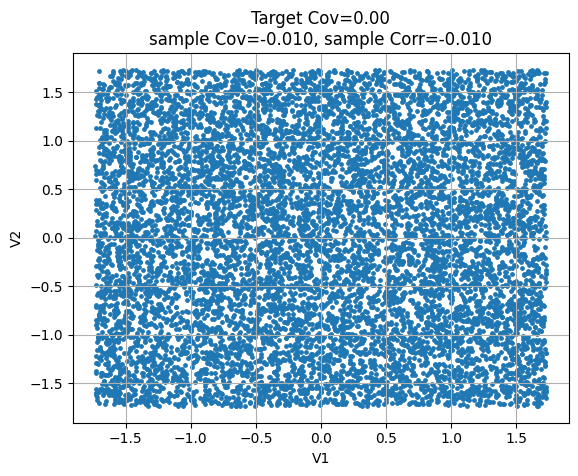

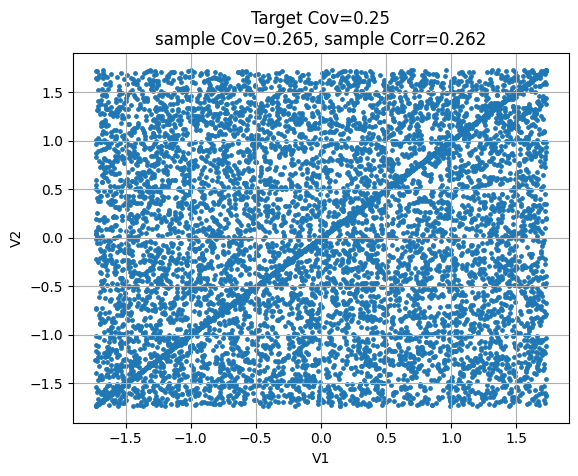

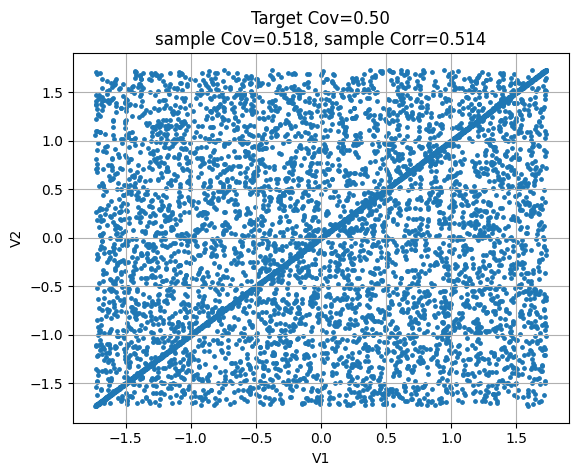

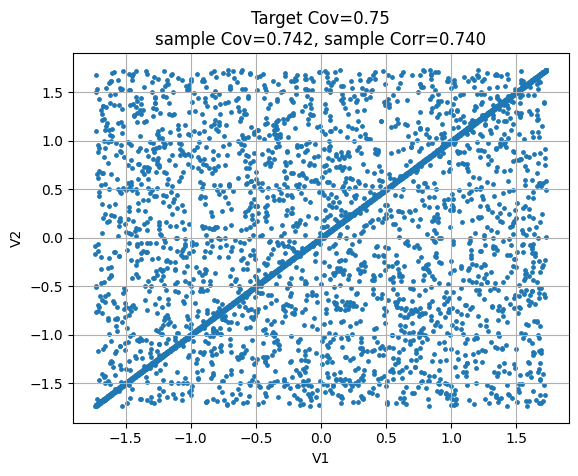

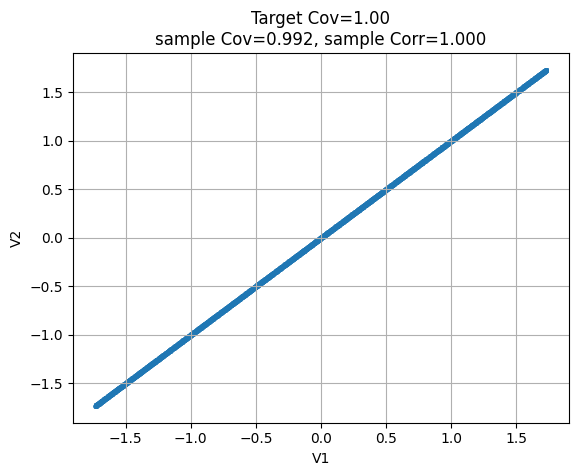

In [ ]:
import matplotlib.pyplot as plt

def correlated_uniforms(sigma12, n=10000, seed=None):
    rng = np.random.default_rng(seed)
    a, b = -np.sqrt(3.0), np.sqrt(3.0)
    X1 = rng.uniform(a, b, size=n)
    X2 = rng.uniform(a, b, size=n)
    p = 1.0 - sigma12
    B = rng.random(n) < p

    V1 = X1
    V2 = np.where(B, X2, X1)
    return V1, V2

targets = [0.0, 0.25, 0.5, 0.75, 1.0]
N = 10000

for idx, sig in enumerate(targets):
    V1, V2 = correlated_uniforms(sig, n=N, seed=4580 + idx)
    sample_cov = np.cov(V1, V2, bias=False)[0,1]
    sample_corr = np.corrcoef(V1, V2)[0,1]

    plt.figure()
    plt.scatter(V1, V2, s=6)
    plt.title(f"Target Cov={sig:.2f}\n"
              f"sample Cov={sample_cov:.3f}, sample Corr={sample_corr:.3f}")
    plt.xlabel("V1")
    plt.ylabel("V2")
    plt.grid(True)
    plt.show()


<hr>

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').

<hr>

## Ans

In [ ]:
sigma12 = 0.5
N = 500_000
V1, V2 = correlated_uniforms(sigma12, n=N, seed=4580)

est = np.mean((V1 <= 0) & (V2 <= 0))
se  = np.sqrt(est * (1 - est) / N)
ci  = (est - 1.96*se, est + 1.96*se)

theory = 0.25 * (1 + sigma12)  # = 3/8

print(f"Estimated P(V1<=0, V2<=0): {est:.6f}")
print(f"Monte Carlo SE: {se:.6f}")
print(f"95% CI: [{ci[0]:.6f}, {ci[1]:.6f}]")
print(f"Theoretical value: {theory:.6f}")


Estimated P(V1<=0, V2<=0): 0.375038
Monte Carlo SE: 0.000685
95% CI: [0.373696, 0.376380]
Theoretical value: 0.375000


<hr>

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

<hr>

## Ans
$U_i = \phi(Z_i)$ ~ $Unif(0,1)$\
$W_i = \alpha + (\beta - \alpha)U_i = \alpha + (\beta - \alpha)\phi(Z_i), i = 1,2$\
$\alpha = -\sqrt{3}, \beta = \sqrt{3}$\
$E[W_i] = \frac{\alpha + \beta}{2} = 0$\
$Var(W_i) = \frac{(\beta - \alpha)^2}{12} = 1$

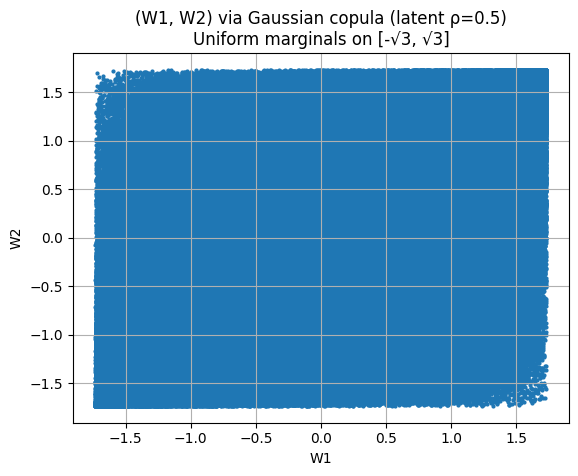

Estimated P(W1≥0, W2≥0): 0.333898
Monte Carlo SE: 0.000667
95% CI: [0.332591, 0.335205]
Means ~ (0,0): -0.0009, 0.0010
Vars  ~ (1,1): 0.9989, 0.9972


In [ ]:
def _approx_erf(x):
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911
    sign = np.sign(x)
    ax = np.abs(x)
    t = 1.0 / (1.0 + p * ax)
    poly = (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t
    y = 1.0 - poly * np.exp(-ax * ax)
    return sign * y

def Phi(x):
    return 0.5 * (1.0 + _approx_erf(x / np.sqrt(2.0)))

def gaussian_copula_uniforms(N, R, seed=None):
    rng = np.random.default_rng(seed)
    L = np.linalg.cholesky(R)
    W = rng.standard_normal((N, 2))
    Z = W @ L.T
    U = Phi(Z)
    return U

def generate_W_from_gaussian_copula(N, alpha, beta, R, seed=None):
    U = gaussian_copula_uniforms(N, R, seed=seed)
    W = alpha + (beta - alpha) * U
    return W[:,0], W[:,1]

# Parameters
alpha, beta = -np.sqrt(3.0), np.sqrt(3.0)
R = np.array([[1.0, 0.5], [0.5, 1.0]])
N = 500_000

W1, W2 = generate_W_from_gaussian_copula(N, alpha, beta, R, seed=4580)

plt.figure()
plt.scatter(W1, W2, s=4)
plt.title("(W1, W2) via Gaussian copula (latent ρ=0.5)\nUniform marginals on [-√3, √3]")
plt.xlabel("W1")
plt.ylabel("W2")
plt.grid(True)
plt.show()

indicator = (W1 >= 0) & (W2 >= 0)
p_hat = indicator.mean()
se = np.sqrt(p_hat * (1 - p_hat) / N)
ci = (p_hat - 1.96*se, p_hat + 1.96*se)

print(f"Estimated P(W1≥0, W2≥0): {p_hat:.6f}")
print(f"Monte Carlo SE: {se:.6f}")
print(f"95% CI: [{ci[0]:.6f}, {ci[1]:.6f}]")

print(f"Means ~ (0,0): {W1.mean():.4f}, {W2.mean():.4f}")
print(f"Vars  ~ (1,1): {W1.var(ddof=1):.4f}, {W2.var(ddof=1):.4f}")
